In [11]:
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [12]:
# Simple Convolutional Autoencoder
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import math
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from model import Model
from utils import *

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
GPU_NUM = int(torch.cuda.device_count())
print(GPU_NUM)

2


In [14]:
# Set Hyperparameters

task_num = 2
#labels = [i for i in range(n_class)]
in_channels = 3 #+ n_class # condition付きのサイズ
out_channels = 3
img_size = (64, 64)
epoch = 20
batch_size = 32
learning_rate = 0.0005

In [15]:
train_dataset = make_dataset('/export/data/dataset/COCO/train2014/',img_size=img_size)
test_dataset = make_dataset('/export/data/dataset/COCO/val2014/',img_size=img_size)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=GPU_NUM)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=GPU_NUM)

## valid

In [16]:
model = Model(in_channels=in_channels, out_channels=out_channels, task_num=task_num).to(device)
model = torch.nn.DataParallel(model)

In [17]:
load_epoch = 20

try:
    param = torch.load('./model/model_{}.pth'.format(load_epoch))
    model.load_state_dict(param)
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

# eval mode
model = model.eval()
loss_func = nn.MSELoss()

images = next(iter(test_loader))
noise = torch.rand(images.shape)
images_noise = torch.add(images.cpu(), 0.3*noise).to(device) # add noise

mask = torch.stack([make_mask(img_size, images.shape[1]) for i in range(images.shape[0])], dim=0)
images_paint = torch.mul(images, mask).to(device) # add mask

images = images.to(device)

with torch.no_grad():
    output_denoising = model(images_noise, task_id=0)
    output_inpainting = model(images_paint, task_id=1)


--------model restored--------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


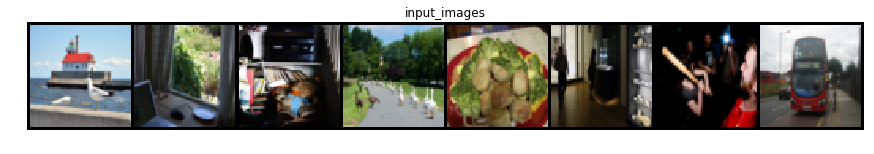

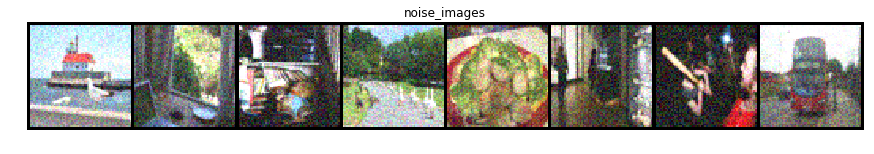

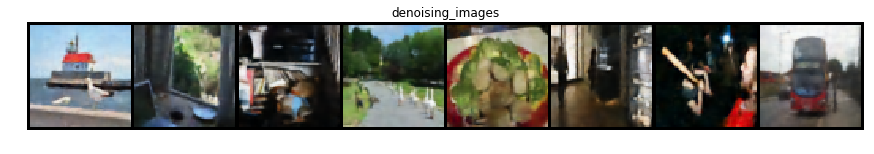

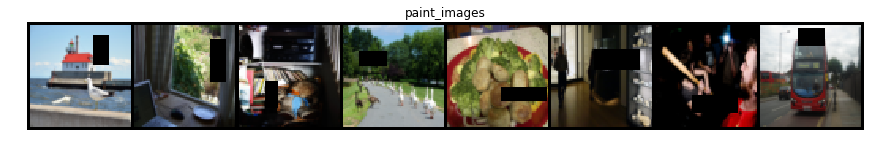

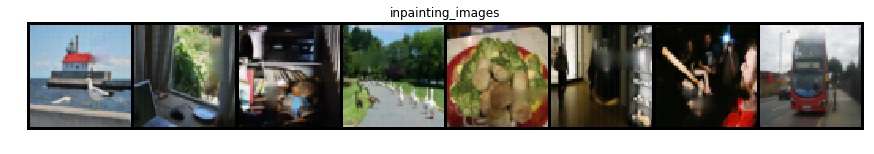

In [18]:
show_img(images.cpu(),'input_images')
show_img(images_noise.cpu(),'noise_images')
show_img(output_denoising.cpu(),'denoising_images')
show_img(images_paint.cpu(),'paint_images')
show_img(output_inpainting.cpu(),'inpainting_images')